<a href="https://colab.research.google.com/github/quangphuc2509/AI-Homework/blob/main/haldpalm_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Khai báo và sử dụng các thư viện sau
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
import os
from PIL import Image
import matplotlib.pyplot as plt
from keras import layers, models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from IPython.display import clear_output
from keras.models import load_model

In [5]:
dataset_url = "/content/drive/MyDrive/haldpalm/train"
data_dir = pathlib.Path(dataset_url)

batch_size = 32 # quét 32 file 1 lần
img_height = 200 # chiều cao bức ảnh
img_width = 200 # Chiều rộng bức ảnh

In [6]:
# Tạo file train với tỉ lệ 80% file data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  validation_split = 0.2,
  subset = "training",
  seed = 100,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Tạo file test với tỉ lệ 20% file data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  validation_split = 0.2,
  subset = "validation",
  seed = 100,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 800 files belonging to 20 classes.
Using 640 files for training.
Found 800 files belonging to 20 classes.
Using 160 files for validation.


In [7]:
# lấy tên các thư mục để làm nhãn cho dữ liệu train
class_names = train_ds.class_names
print(class_names)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020']


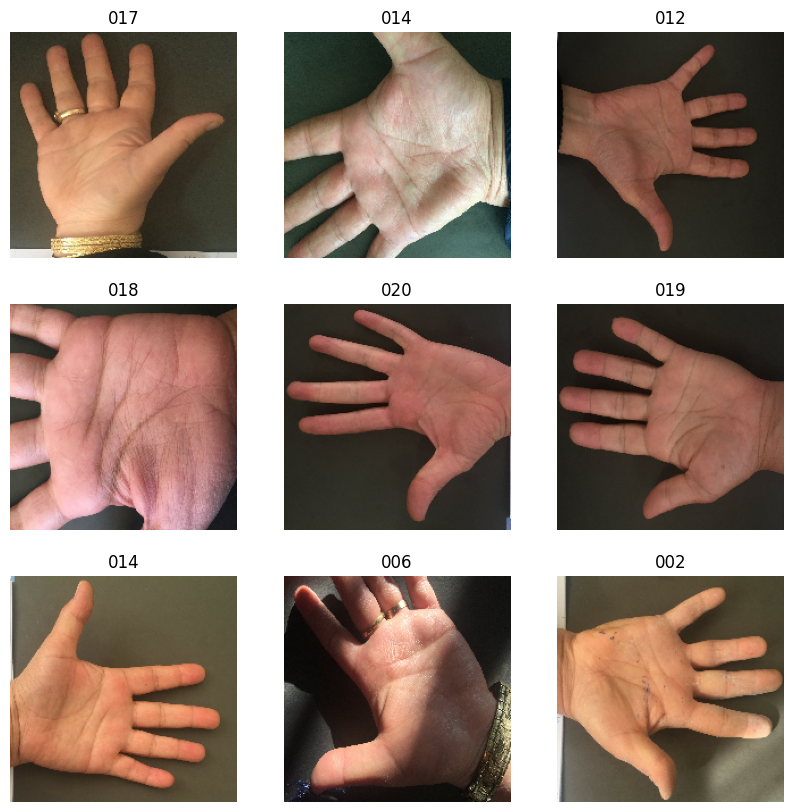

In [8]:
# In ra một số ảnh thuộc dữ liệu train
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
# kiểm tra kiểu dữ liệu trong dữ liệu train
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 200, 200, 3)
(32,)


In [10]:
num_classes = len(class_names)
# Tạo mô hình Sequential
model = Sequential()
# Chuẩn hóa giá trị pixel từ 0-255 về 0-1
model.add(Rescaling(1./255))

# Tạo lớp Convolution với bộ lọc 3x3, activation là hàm phi tuyến
model.add(Conv2D(32, kernel_size = 3, activation = "relu", 
                 input_shape = (200, 200, 3), padding = "same"))
model.add(MaxPooling2D((2, 2), padding = "same"))

model.add(Conv2D(64, kernel_size = 3, activation = "relu", padding = "same"))
model.add(MaxPooling2D((2, 2), padding = "same"))

model.add(Conv2D(128, kernel_size = 3, activation = "relu", padding = "same"))
model.add(MaxPooling2D((2, 2), padding = "same"))

# Chuyển đổi đầu ra các lớp convolution thành mảng 1 chiều
model.add(Flatten())

# Tạo lớp ẩn
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

# Biên dịch Mô hình, ở đây sử dụng SparseCategoricalCrossentropy để tính toán mất mát của mô hình
# dựa trên xác suất dự đoán của mô hình và chỉ số của lớp thực sự của dữ liệu.
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [11]:
# Tạo hàm callback, Trong đó
# class chứa câu lệnh được thực hiện khi két thúc 1 epoch
class DisplayCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True) # Xóa nội dung hiện tại trên console

# EarlyStopping: dừng quá trình train sớm nếu mô hình không cải thiện độ chính xác 
#               trên tập validation trong một số epoch liên tiếp (patience)
# ReduceLROnPlateau: giảm learning rate nếu độ chính xác trên tập validation 
#                 không cải thiện trong một số epoch liên tiếp
# ModelCheckpoint: lưu trữ các check point tốt nhất sau mỗi epoch
callbacks = [DisplayCallback(), 
            EarlyStopping(patience=20, verbose=1),                  
            ReduceLROnPlateau(patience=5, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/haldpalm/haldpalm.h5', 
                            verbose=1, save_best_only=True)]

In [12]:
# train mô hình 
history = model.fit(
          train_ds,
          validation_data = val_ds,
          epochs = 50,
          callbacks = callbacks)


Epoch 29: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 29: val_loss did not improve from 0.44555
20/20 [==============================] - 24s 772ms/step - loss: 8.2544e-05 - accuracy: 1.0000 - val_loss: 0.4914 - val_accuracy: 0.9125 - lr: 1.0000e-06
Epoch 29: early stopping


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       7

In [13]:
# Đánh giá độ chính xác của mô hình 
Score=model.evaluate(val_ds,verbose=0)
print('Loss', Score[0])
print('Accuracy', Score[1])

Loss 0.4913555979728699
Accuracy 0.9125000238418579


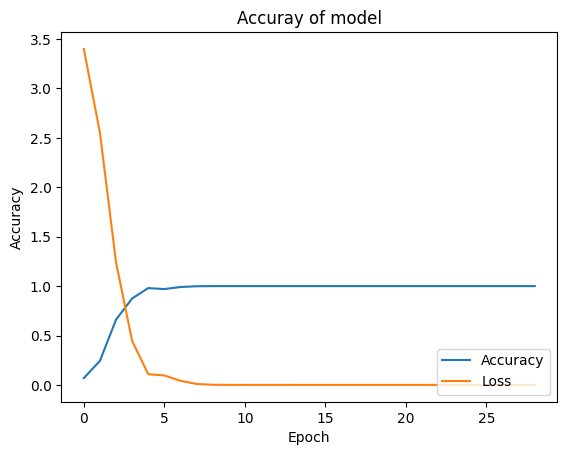

In [14]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("Accuray of model")

plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.legend(["Accuracy", "Loss"], loc = "lower right")

1/1 [==============================] - 0s 19ms/step
Predict: 008


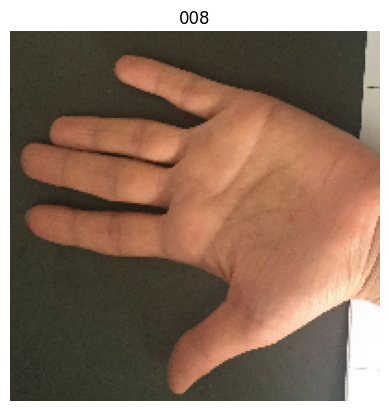

In [16]:
# kiểm tra lại khả năng dự đoán của mô hình 
for images, labels in val_ds.take(1):
  
  plt.imshow(images[1].numpy().astype("uint8"))
  plt.title(class_names[labels[1]])
  plt.axis("off")
  
  img = np.expand_dims(images[1], axis = 0)
  
  print('Predict:',class_names[np.argmax(model.predict(img))])

1/1 [==============================] - 0s 18ms/step
Predict: 004


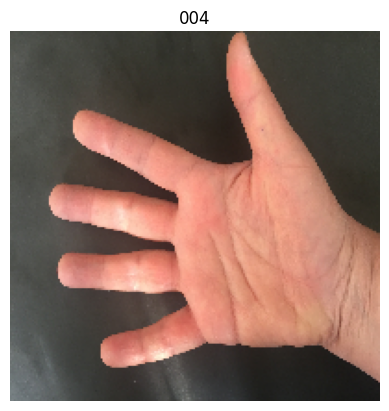

In [17]:
# kiểm tra lại khả năng dự đoán của mô hình 
for images, labels in val_ds.take(1):
  
  plt.imshow(images[1].numpy().astype("uint8"))
  plt.title(class_names[labels[1]])
  plt.axis("off")
  
  img = np.expand_dims(images[1], axis = 0)
  
  print('Predict:',class_names[np.argmax(model.predict(img))])